**Name:** YANG Yongze

**EID:** 58162280

# CS5489 - Tutorial 4
## Face Detection in Images

In this tutorial you will train a classifier to detect whether there is a face in a small image patch.  This type of face detector is used in your phone and camera whenever you take a picture!

First we need to initialize Python.  Run the below cell.

In [2]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
from scipy import ndimage
from scipy import signal
from scipy import stats
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
import xgboost as xgb

## Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [6]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 4  
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile, as_gray=True) # read as grayscale
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

1745
944


Each image is a 19x19 array of pixel values.  Run the below code to show an example:

(19, 19)


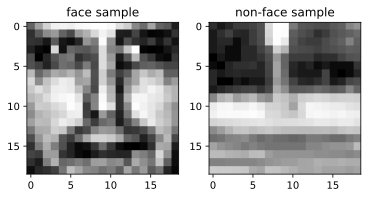

In [7]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(imgdata['train'][0], cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(imgdata['train'][trainclass2start], cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

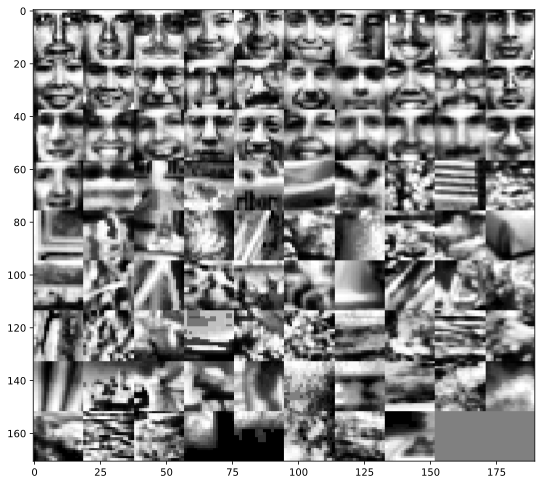

In [8]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show a few images
plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata['train'][::20]), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [9]:
trainX = empty((len(imgdata['train']), prod(imgsize)))
for i,img in enumerate(imgdata['train']):
    trainX[i,:] = ravel(img)
trainY = asarray(classes['train'])  # convert list to numpy array
print(trainX.shape)
print(trainY.shape)

testX = empty((len(imgdata['test']), prod(imgsize)))
for i,img in enumerate(imgdata['test']):
    testX[i,:] = ravel(img)
testY = asarray(classes['test'])  # convert list to numpy array
print(testX.shape)
print(testY.shape)

(1745, 361)
(1745,)
(944, 361)
(944,)


## Detection using  pixel values

Train an AdaBoost and GradientBoosting classifiers to classify an image patch as face or non-face.  Also train a kernel SVM classifier using either RBF or polynomial kernel, and a Random Forest Classifier.  Evaluate all your classifiers on the test set.

First we will normalize the features.

In [10]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXn = scaler.fit_transform(trainX)   # use training data to fit scaling parameters
testXn  = scaler.transform(testX)        # apply scaling to test data

Let's Use Grid Search to get the best parameters.

AdaBoost Classifier

In [11]:
# Ada Boost
paramgrid_ada = {'learning_rate':logspace(-6,0,20), 'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000])}

ada_cv = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(),param_grid=paramgrid_ada,cv=5,n_jobs=-1)

ada_cv.fit(trainXn,trainY)
print('[ADA]best params: ', ada_cv.best_params_)

[ADA]best params: {'learning_rate': 1.0, 'n_estimators': 500}


XGBoost Classifier

In [12]:
# Gradient Boost
import xgboost as xgb
xclf = xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss',
 random_state=4487, use_label_encoder=False)

paramgrid_xgb = {'learning_rate': logspace(-6,0,20),
 'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000])
 }

xgb_cv = model_selection.GridSearchCV(xclf,param_grid=paramgrid_xgb,cv=5,n_jobs=-1)

xgb_cv.fit(trainXn, trainY)
print('[XGB] best params: ', xgb_cv.best_params_)


C:\Users\yyz\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\yyz\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\yyz\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[XGB] best params:  {'learning_rate': 0.11288378916846883, 'n_estimators': 500}


In [13]:
# Support Vector Machine
paramgrid_svm = {'C': logspace(-2, 2, 10), 'gamma': logspace(-2, 2, 20)}
svm_cv = model_selection.GridSearchCV(svm.SVC(kernel='rbf'),param_grid=paramgrid_svm,cv=5,n_jobs=-1)
svm_cv.fit(trainXn,trainY)
print('[SVM] best params: ', svm_cv.best_params_)

[SVM] best params:  {'C': 1.6681005372000592, 'gamma': 0.016237767391887217}


In [14]:
# Random Forest
paramgrid_rf = {'n_estimators':[5, 10, 50, 100, 500, 1000]}
rf_cv = model_selection.GridSearchCV(ensemble.RandomForestClassifier(),param_grid=paramgrid_rf,cv=5,n_jobs=-1)
rf_cv.fit(trainXn,trainY)
print('[RF] best params: ', rf_cv.best_params_)

[RF] best params:  {'n_estimators': 1000}


Now we know the best parameters are shown below:
- \[ADA\] best params: {'learning_rate': 1.0, 'n_estimators': 500}
- \[XGB\] best params: {'learning_rate': 0.11288378916846883, 'n_estimators': 500}
- \[SVM\] best params: {'C': 1.6681005372000592, 'gamma': 0.016237767391887217}
- \[RF\] best params:  {'n_estimators': 1000}

Then seperately train these models using the best parameters:

In [16]:
adaclf = ensemble.AdaBoostClassifier(**ada_cv.best_params_)
adaclf.fit(trainXn,trainY)
predictY_ada = adaclf.predict(testXn)

xgbclf = xgb.XGBClassifier(**xgb_cv.best_params_, objective="binary:logistic", eval_metric='logloss',
 random_state=4487, use_label_encoder=False)
xgbclf.fit(trainXn,trainY)
predictY_xgb = xgbclf.predict(testXn)

svmclf = svm.SVC(**svm_cv.best_params_, kernel='rbf')
svmclf.fit(trainXn,trainY)
predictY_svm = svmclf.predict(testXn)

rfclf = ensemble.RandomForestClassifier(**rf_cv.best_params_)
rfclf.fit(trainXn,trainY)
predictY_rf = rfclf.predict(testXn)

print('[ADA] Accuracy', metrics.accuracy_score(testY, predictY_ada))
print('[XGB] Accuracy', metrics.accuracy_score(testY, predictY_xgb))
print('[SVM] Accuracy', metrics.accuracy_score(testY, predictY_svm))
print('[RF] Accuracy', metrics.accuracy_score(testY, predictY_rf))


C:\Users\yyz\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[ADA] Accuracy 0.638771186440678
[XGB] Accuracy 0.6483050847457628
[SVM] Accuracy 0.6567796610169492
[RF] Accuracy 0.6684322033898306


_Which classifier was best?_
- According to the result, the Random Forest Classifier has the best accuracy.

### Error analysis
The accuracy only tells part of the classifier's performance. We can also look at the different types of errors that the classifier makes:
- _True Positive (TP)_: classifier correctly said face
- _True Negative (TN)_: classifier correctly said non-face
- _False Positive (FP)_: classifier said face, but not a face
- _False Negative (FN)_: classifier said non-face, but was a face

This is summarized in the following table:

<table>
<tr><th colspan=2 rowspan=2><th colspan=2 style="text-align: center">Actual</th></tr>
<tr>  <th>Face</th><th>Non-face</th></tr>
<tr><th rowspan=2>Prediction</th><th>Face</th><td>True Positive (TP)</td><td>False Positive (FP)</td></tr>
<tr>  <th>Non-face</th><td>False Negative (FN)</td><td>True Negative (TN)</td></tr>
</table>

We can then look at the _true positive rate_ and the _false positive rate_.
- _true positive rate (TPR)_: proportion of true faces that were correctly detected
- _false positive rate (FPR)_: proportion of non-faces that were mis-classified as faces.

Use the below code to calculate the TPR and FPR of your classifiers.

In [17]:
# predY is the prediction from the classifier
def assess(predY, clf_name):
    Pind = where(predY==1) # indicies for face predictions
    Nind = where(predY==0) # indicies for non-face predictions
    TP = count_nonzero(testY[Pind] == predY[Pind])
    FP = count_nonzero(testY[Pind] != predY[Pind])
    TN = count_nonzero(testY[Nind] == predY[Nind])
    FN = count_nonzero(testY[Nind] != predY[Nind])

    TPR = TP / (TP+FN)
    FPR = FP / (FP+TN)
    print('***' + clf_name + '***')
    print("TP=", TP)
    print("FP=", FP)
    print("TN=", TN)
    print("FN=", FN)
    print("TPR=", TPR)
    print("FPR=", FPR)

assess(predictY_ada, 'ADA')
assess(predictY_xgb, 'XGB')
assess(predictY_svm, 'SVM')
assess(predictY_rf, 'RF')


***ADA***
TP= 134
FP= 3
TN= 469
FN= 338
TPR= 0.2838983050847458
FPR= 0.006355932203389831
***XGB***
TP= 144
FP= 4
TN= 468
FN= 328
TPR= 0.3050847457627119
FPR= 0.00847457627118644
***SVM***
TP= 149
FP= 1
TN= 471
FN= 323
TPR= 0.3156779661016949
FPR= 0.00211864406779661
***RF***
TP= 163
FP= 4
TN= 468
FN= 309
TPR= 0.3453389830508475
FPR= 0.00847457627118644


_How does the classifier make errors?_
- In these four classifiers, the number of FPs is low but the number of FNs is high, which means that the main errors made by these classifiers are the false prediction of faces as non-faces. Maybe these models are too conservative in predicting faces samples, resulting in missing some faces positives.

### Classifier analysis

For the AdaBoost classifier, we can interpret what it is doing by looking at which features it uses most in the weak learners.  Use the below code to visualize the pixel features used.

Note: if you used GridSearchCV to train the classifier, then you need to use the `best_estimator_` field to access the classifier.

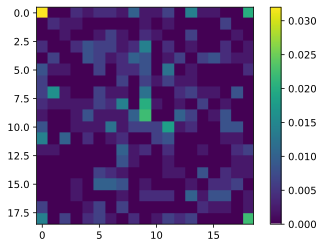

In [18]:
# adaclf is the trained adaboost classifier
fi = adaclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Similarly, we can also look at the important features for xgboost.

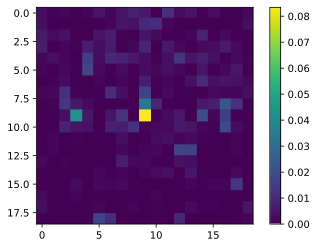

In [19]:
# xgbclf is the trained xgboost classifier
fi = xgbclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Similarly for Random Forests, we can look at the important features.

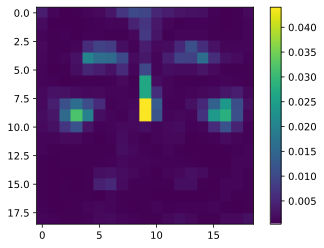

In [20]:
# rfclf is the trained random forest classifier
fi = rfclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Comment on which features (pixels) that AdaBoost and Random Forests are using
- AdaBoost classifier: it focuses on the pixels in the four corners, especially in the upper left corner. In addition, it also focuses on the small portion of pixels concentrated in the middle of the image (the tip of the nose). For the other parts there is an irregular distribution of the feature values, with a little higher value on the left.

- Gradient boosting classifier: it focuses the most on the pixel point in the middle (the tip of the nose), then to a pixel where the left cheek is located, and then to a small part of the pixel where the right cheek is located.

- Random Forest classifier: the tip pixel of the nose has the highest feature value, followed by the cheeks on both sides, the eyes, and the forehead, which appears to be roughly symmetrical.

- I think the Random Forest classifier is the best classifier among there 3 classifiers since anyone can recognize a human face from the figure.

For kernel SVM, we can look at the support vectors to see what the classifier finds difficult.

num support vectors: 556


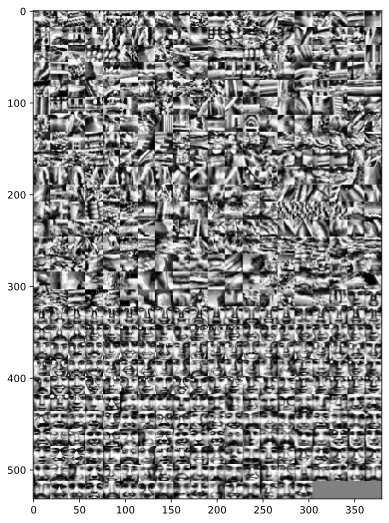

In [21]:
# svmclf is the trained SVM classifier

print("num support vectors:", len(svmclf.support_vectors_))
si  = svmclf.support_  # get indicies of support vectors

# get all the patches for each support vector
simg = [ imgdata['train'][i] for i in si ]

# make montage
outimg = image_montage(simg, maxw=20)

plt.figure(figsize=(9,9))
plt.imshow(outimg, cmap='gray', interpolation='nearest')

Comment on anything you notice about what the SVM finds difficult (i.e., on the decision boundary or within the margin)
- The non-face vectors of SVMs are higher than faces, which may lead to the fact that SVMs are better at predicting non-faces, which explains the fact that SVMs have the highest number of True Negatives and the lowest number of False Positive of all classifiers.
- As decision boundaries, SVMs may have a harder time recognising faces wearing glasses, faces with beards and non-faces containing rectangles or polygons.

### Custom kernel SVM

Now we will try to use a custom kernel with the SVM.  We will consider the following RBF-like kernel based on L1 distance (i.e., cityblock or Manhattan distance),

$$ k(\mathbf{x},\mathbf{y}) = \exp \left(-\alpha \sum_{i=1}^d |x_i-y_i|\right)$$

where $x_i,y_i$ are the elements of the vectors $\mathbf{x},\mathbf{y}$, and $\alpha$ is the hyperparameter.  The difference with the RBF kernel is that the new kernel uses the absolute difference rather than the squared difference. Thus, the new kernel does not "drop off" as fast as the RBF kernel using squared distance.

- Implement the new kernel as a custom kernel function. The `scipy.spatial.distance.cdist` function will be helpful.
- Train the SVM with the new kernel.  To select the hyperparameter $\alpha$, you need to run cross-validation "manually" by: 1) trying different values of $\alpha$, and running cross-validation to select $C$; 2) selecting the  $\alpha$ with the highest cross-validation score `best_score_` in `GridSearchCV`.


In [23]:
### INSERT YOUR CODE HERE
from scipy import spatial

def custom_kernel(X1, X2, alpha = 1.0):
    """
    Customized kernel using Manhattan Distance.
    """
    distance = spatial.distance.cdist(X1, X2, metric='cityblock')
    return exp(-alpha * distance)

Use Grid Search to get the best $\alpha$ and the best $C$.

In [25]:
from functools import partial

alphas =  [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
param_grid = {'C': logspace(-3,2,10)}
best_params, best_score =0,0
best_alpha = -1

for a in alphas:
    kernel = partial(custom_kernel, alpha=a)
    my_svm = svm.SVC(kernel = kernel)

    grid_search = model_selection.GridSearchCV(my_svm, param_grid,cv = 5, n_jobs = -1)

    grid_search.fit(trainXn,trainY)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_alpha = a
        best_params = grid_search.best_params_

print('Best alpha: ', best_alpha)
print('Best params: ', best_params)


Best alpha:  0.01
Best params:  {'C': 2.1544346900318843}


Using these parameters to train and test.

In [26]:
newsvm = svm.SVC(C = 2.1544346900318843
, kernel = partial(custom_kernel, alpha=0.01))

newsvm.fit(trainXn,trainY)
predictY_newsvm = newsvm.predict(testXn)

assess(predictY_newsvm, 'NewSVM')
print('[NewSVM] Accuracy: ', metrics.accuracy_score(testY,predictY_newsvm))

***NewSVM***
TP= 156
FP= 1
TN= 471
FN= 316
TPR= 0.3305084745762712
FPR= 0.00211864406779661
[NewSVM] Accuracy:  0.6641949152542372


Does using the new kernel improve the results?
- SVMs with the new kernel are slightly more accurate than the original SVMs.

## Image Feature Extraction
The detection performance is not that good. The problem is that we are using the raw pixel values as features, so it is difficult for the classifier to interpret larger structures of the face that might be important.  To fix the problem, we will extract features from the image using a set of filters.

Run the below code to look at the filter output.  The filters are a sets of black and white boxes that respond to similar structures in the image.  After applying the filters to the image, the filter response map is aggregated over a 4x4 window.  Hence each filter produces a 5x5 feature response.  Since there are 4 filters, then the feature vector is 100 dimensions.

In [32]:
def extract_features(imgs, doplot=False):
    # the filter layout
    lay = [array([-1,1]), array([-1,1,-1]),  
               array([[1],[-1]]), array([[-1],[1],[-1]])]
    sc=8            # size of each filter patch
    poolmode = 'i'  # pooling mode (interpolate)
    cmode = 'same'  # convolution mode
    brick = ones((sc,sc))  # filter patch
    ks = []
    for l in lay:
        tmp = [brick*i for i in l]
        if (l.ndim==1):
            k = hstack(tmp)
        else:
            k = vstack(tmp)
        ks.append(k)

    # get the filter response size
    if (poolmode=='max') or (poolmode=='absmax'):
        tmpimg = maxpool(maxpool(imgs[0]))
    else:
        tmpimg = ndimage.zoom(imgs[0], 0.25)        
    fs = prod(tmpimg.shape)
    
    # get the total feature length
    fst = fs*len(ks)

    # filter the images
    X  = empty((len(imgs), fst))
    for i,img in enumerate(imgs):
        x = empty(fst)

        # for each filter
        for j,th in enumerate(ks):
            # filter the image
            imgk = signal.convolve(img, ks[j], mode=cmode)
            
            # do pooling
            if poolmode == 'maxabs':
                mimg = maxpool(maxpool(abs(imgk)))
            elif poolmode == 'max':
                mimg = maxpool(maxpool(imgk))
            else:
                mimg = ndimage.zoom(imgk, 0.25)
    
            # put responses into feature vector
            x[(j*fs):(j+1)*fs] = ravel(mimg)
               
            if (doplot):             
                plt.subplot(3,len(ks),j+1)
                plt.imshow(ks[j], cmap='gray', interpolation='nearest')
                plt.title("filter " + str(j))
                plt.subplot(3,len(ks),len(ks)+j+1)
                plt.imshow(imgk, cmap='gray', interpolation='nearest')
                plt.title("filtered image")
                plt.subplot(3,len(ks),2*len(ks)+j+1)
                plt.imshow(mimg, cmap='gray', interpolation='nearest')
                plt.title("image features")
        X[i,:] = x
    
    return X

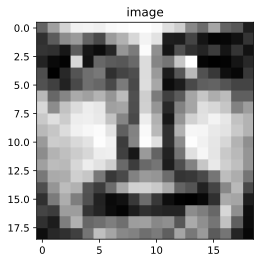

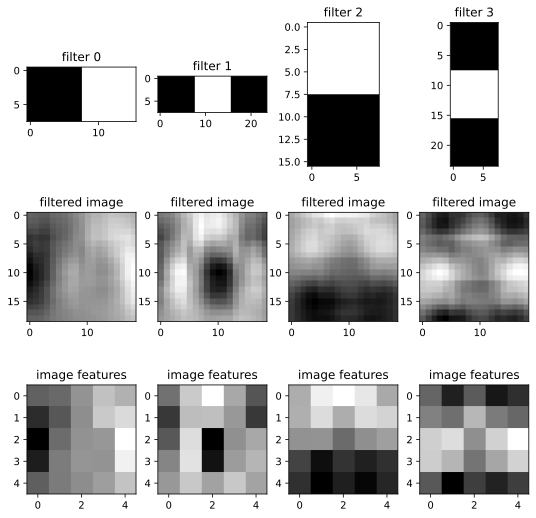

In [33]:
# new features
img = imgdata['train'][0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("image")
plt.figure(figsize=(9,9))
extract_features([img], doplot=True);

Now lets extract image features on the training and test sets.  It may take a few seconds.

In [34]:
trainXf = extract_features(imgdata['train'])
print(trainXf.shape)
testXf = extract_features(imgdata['test'])
print(testXf.shape)

(1745, 100)
(944, 100)


### Detection using Image Features
Now train AdaBoost and SVM classifiers on the image feature data.  Evaluate on the test set.

In [35]:
# first scale the features
scalerf = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXfn = scalerf.fit_transform(trainXf)   # use training data to fit scaling parameters
testXfn  = scalerf.transform(testXf)        # apply scaling to test data

In [36]:
### INSERT YOUR CODE HERE

Use Grid Search to get the best parameters.

In [37]:
# Ada Boost
paramgrid_ada = {'learning_rate':logspace(-6,0,20), 'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000])}

ada_cv = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(),param_grid=paramgrid_ada,cv=5,n_jobs=-1)

ada_cv.fit(trainXfn,trainY)
print('[ADA]best params: ', ada_cv.best_params_)

# Support Vector Machine
paramgrid_svm = {'C': logspace(-2, 2, 10), 'gamma': logspace(-2, 2, 20)}
svm_cv = model_selection.GridSearchCV(svm.SVC(kernel='rbf'),param_grid=paramgrid_svm,cv=5,n_jobs=-1)
svm_cv.fit(trainXfn,trainY)
print('[SVM] best params: ', svm_cv.best_params_)

[ADA]best params:  {'learning_rate': 0.4832930238571752, 'n_estimators': 1000}
[SVM] best params:  {'C': 100.0, 'gamma': 0.026366508987303583}


In [40]:
# Support Vector Machine using poly kernel
paramgrid_svm = {'C': logspace(-2, 2, 10), 'gamma': logspace(-2, 2, 20)}
svm_cv = model_selection.GridSearchCV(svm.SVC(kernel='poly'),param_grid=paramgrid_svm,cv=5,n_jobs=-1)
svm_cv.fit(trainXfn,trainY)
print('[SVM_poly] best params: ', svm_cv.best_params_)

[SVM_poly] best params:  {'C': 100.0, 'gamma': 0.04281332398719394}


Train models using the best parameters .

In [42]:
ada_new = ensemble.AdaBoostClassifier(learning_rate=0.4832930238571752, n_estimators=1000)
svm_new = svm.SVC(C=100.0, gamma=0.04281332398719394, kernel='poly')

ada_new.fit(trainXfn,trainY)
svm_new.fit(trainXfn,trainY)

predictY_ada_new = ada_new.predict(testXfn)
predictY_svm_new = svm_new.predict(testXfn)

print('[ADA] Accuracy: ', metrics.accuracy_score(testY,predictY_ada_new))
print('[SVM] Accuracy: ', metrics.accuracy_score(testY,predictY_svm_new))

[ADA] Accuracy:  0.7457627118644068
[SVM] Accuracy:  0.8029661016949152


### Error Analysis
Repeat the error analysis for the new classifiers.

In [43]:
### INSERT YOUR CODE HERE
assess(predictY_ada_new, 'ADA_new')
assess(predictY_svm_new, 'SVM_new')

***ADA_new***
TP= 251
FP= 19
TN= 453
FN= 221
TPR= 0.5317796610169492
FPR= 0.04025423728813559
***SVM_new***
TP= 296
FP= 10
TN= 462
FN= 176
TPR= 0.6271186440677966
FPR= 0.0211864406779661


How has the classifier using image features improved?
- The accuracy is much better than before.
- The number of false positives is quite a bit higher than before, which means that the model is not predicting positive samples as harshly as before.
- The number of false negative is quite a bit less than before, which means the model can predict negative samples more accurately than before.

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [44]:
fname = "nasa-small.png"

(210, 480)


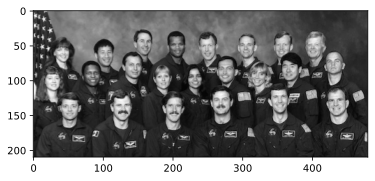

In [45]:
# load image
testimg = skimage.io.imread(fname, as_gray=True)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [46]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3]))
print(patches2.shape )

# histogram equalize patches (improves contrast)
patches3 = empty(patches2.shape)
for i in range(patches2.shape[0]):
    patches3[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])

# extract features
newXf = extract_features(patches3)

(5568, 19, 19)


Now predict using your classifier.  The extracted features are in `newXf`, and scaled features are `newXfn`.

In [47]:
newXfn  = scalerf.transform(newXf)        # apply scaling to test data

In [48]:
predY_ada_newXfn = ada_new.predict(newXfn)
predY_svm_newXfn = svm_new.predict(newXfn)


Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

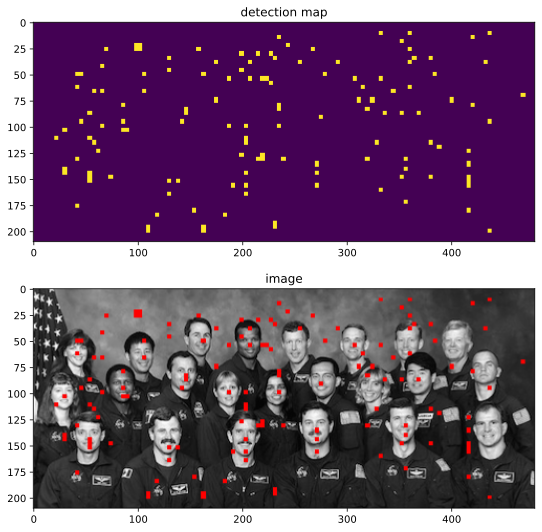

In [50]:
# Use data predicted by Support Vector Machine
prednewY = predY_svm_newXfn
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

(-0.5, 479.5, 209.5, -0.5)

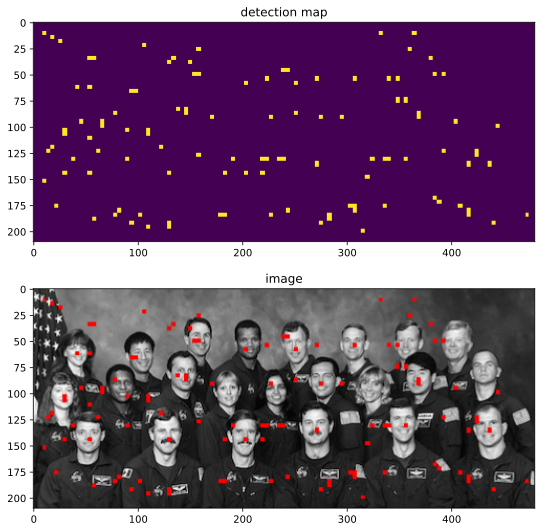

In [51]:
# # Use data predicted by Ada Boosting classifier
prednewY = predY_ada_newXfn
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))

# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do?_
- Support Vector Machine: SVM mainly checked the recognition of nose and head as faces. However, at the same time, it incorrectly recognised parts such as shoulder straps, chest badges and backgrounds as faces.
- Ada Boost classifier: The AdaBoostClassifier mainly uses the tip of the nose and the left cheek for recognition. Similar to SVM, this classifier uses more clothing decorations such as badges and some of the background blocks as features for face recognition, and it even uses the stars of the American flag as part of the face recognition.
- Both algorithms have a small number of unrecognizable faces and incorrectly recognize many non-face parts as faces.

You can try it on your own images.  The faces should all be around 19x19 pixels though. We only used 1/4 of the training data. Try using more data to train it!